In [1]:
# Imports
import os 
from predictionguard import PredictionGuard
import pandas as pd 
import json
from langchain.prompts import PromptTemplate, FewShotPromptTemplate
import numpy as np
from torch import nn
from skorch import NeuralNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from torch.optim import Adam
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
df_meta_model = pd.read_csv('examples.csv')
df= pd.read_csv('AugmentedData.csv')
df2 = pd.read_csv('surprisemebrother_60.csv')

In [3]:
#drop q21 and q22 for all df
df = df.drop(['q21', 'q22'], axis=1)
df2 = df2.drop(['q21', 'q22'], axis=1)
df_meta_model = df_meta_model.drop(['q21', 'q22'], axis=1)

In [4]:
final_df = pd.concat([df, df2], ignore_index=True)

In [5]:
final_df.head()

,Unnamed: 0,Id,q1,q2,q3,q4,q5,q6,q7,q8,...,q12,q13,q14,q15,q16,q17,q18,q19,q20,label
0,0.0,"0_ Immediate Grief, Shock, and Emotion",1,7,0,0,0,0,2,3,...,0,1,3,0,0,1,0,0,1,1
1,1.0,0_ Navigating Family Relationships,1,0,0,1,1,0,1,3,...,0,0,3,1,1,1,0,2,1,2
2,2.0,0_ Learning to Process Grief,1,4,1,1,1,1,1,2,...,0,2,2,1,1,2,Considering,2,2,3
3,3.0,0_ Moments That Matter,1,I found,1,1,1,1,1,1,...,0,2,2,1,2,1,0,2,2,4
4,4.0,"0_ Feeling Immersed, Connected & Seen",1,0,2,2,2,2,0,1,...,2,2,2,2,2,2,1,3,2,5


In [6]:
final_df = final_df.drop('Unnamed: 0', axis=1)

In [7]:
final_df.head()

,Id,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,q12,q13,q14,q15,q16,q17,q18,q19,q20,label
0,"0_ Immediate Grief, Shock, and Emotion",1,7,0,0,0,0,2,3,0,...,0,1,3,0,0,1,0,0,1,1
1,0_ Navigating Family Relationships,1,0,0,1,1,0,1,3,1,...,0,0,3,1,1,1,0,2,1,2
2,0_ Learning to Process Grief,1,4,1,1,1,1,1,2,1,...,0,2,2,1,1,2,Considering,2,2,3
3,0_ Moments That Matter,1,I found,1,1,1,1,1,1,1,...,0,2,2,1,2,1,0,2,2,4
4,"0_ Feeling Immersed, Connected & Seen",1,0,2,2,2,2,0,1,2,...,2,2,2,2,2,2,1,3,2,5


In [8]:
# List of question columns
question_columns = [f"q{i}" for i in range(1, 21)]

# Convert non-numeric values in each question column to NaN
final_df[question_columns] = final_df[question_columns].apply(pd.to_numeric, errors='coerce')

# Display the result to verify changes
final_df.head()

,Id,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,q12,q13,q14,q15,q16,q17,q18,q19,q20,label
0,"0_ Immediate Grief, Shock, and Emotion",1.0,7.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,...,0,1.0,3.0,0.0,0.0,1.0,0.0,0,1,1
1,0_ Navigating Family Relationships,1.0,0.0,0.0,1.0,1.0,0.0,1.0,3.0,1.0,...,0,0.0,3.0,1.0,1.0,1.0,0.0,2,1,2
2,0_ Learning to Process Grief,1.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,0,2.0,2.0,1.0,1.0,2.0,NaN,2,2,3
3,0_ Moments That Matter,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,2.0,2.0,1.0,2.0,1.0,0.0,2,2,4
4,"0_ Feeling Immersed, Connected & Seen",1.0,0.0,2.0,2.0,2.0,2.0,0.0,1.0,2.0,...,2,2.0,2.0,2.0,2.0,2.0,1.0,3,2,5


In [9]:
for col in [f"q{i}" for i in range(1, 21)]:
    mean_val = final_df[col].mean()  # Calculate mean
    final_df[col].fillna(mean_val, inplace=True)  # Fill NaNs in train data with mean
    df_meta_model[col].fillna(mean_val, inplace=True)   # Fill NaNs in test data with mean

    final_df[col] = final_df[col].round().astype(int)
    df_meta_model[col] = df_meta_model[col].round().astype(int)

/var/folders/_m/skhgc3n53pbfz_6qdt170bs40000gp/T/ipykernel_3017/190434401.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df[col].fillna(mean_val, inplace=True)  # Fill NaNs in train data with mean
/var/folders/_m/skhgc3n53pbfz_6qdt170bs40000gp/T/ipykernel_3017/190434401.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whi

In [10]:
#Convert columns q1 to q20 to float
final_df['q1'] = final_df['q1'].astype(float)
final_df['q2'] = final_df['q2'].astype(float)
final_df['q3'] = final_df['q3'].astype(float)
final_df['q4'] = final_df['q4'].astype(float)
final_df['q5'] = final_df['q5'].astype(float)
final_df['q6'] = final_df['q6'].astype(float)
final_df['q7'] = final_df['q7'].astype(float)
final_df['q8'] = final_df['q8'].astype(float)
final_df['q9'] = final_df['q9'].astype(float)
final_df['q10'] = final_df['q10'].astype(float)
final_df['q11'] = final_df['q11'].astype(float)
final_df['q12'] = final_df['q12'].astype(float)
final_df['q13'] = final_df['q13'].astype(float)
final_df['q14'] = final_df['q14'].astype(float)
final_df['q15'] = final_df['q15'].astype(float)
final_df['q16'] = final_df['q16'].astype(float)
final_df['q17'] = final_df['q17'].astype(float)
final_df['q18'] = final_df['q18'].astype(float)
final_df['q19'] = final_df['q19'].astype(float)
final_df['q20'] = final_df['q20'].astype(float)

In [11]:
print("Missing values in train data:", final_df.isnull().sum().sum())
print("Missing values in test data:", df_meta_model.isnull().sum().sum())

Missing values in train data: 0
Missing values in test data: 0


In [12]:
final_df['label'] = final_df['label']-1

In [13]:
#Train test split on final df
X_train = final_df.drop(['Id','label'], axis=1)
y_train = final_df['label']

In [14]:
# Parameter grids for each model
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Parameter grid for the Decision Tree
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [15]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=0)
grid_search_rf.fit(X_train, y_train)
print("Best RF parameters:", grid_search_rf.best_params_)
print("Best RF F1:", grid_search_rf.best_score_)

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=0)
grid_search_gb.fit(X_train, y_train)
print("Best GB parameters:", grid_search_gb.best_params_)
print("Best GB F1:", grid_search_gb.best_score_)

# Support Vector Classifier
svc = SVC(probability=True, random_state=42)
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svc, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=0)
grid_search_svc.fit(X_train, y_train)
print("Best SVC parameters:", grid_search_svc.best_params_)
print("Best SVC F1:", grid_search_svc.best_score_)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=0)
grid_search_dt.fit(X_train, y_train)
print("Best DT parameters:", grid_search_dt.best_params_)
print("Best DT F1:", grid_search_dt.best_score_)

Best RF parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
Best RF F1: 0.8565559289984014
Best GB parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Best GB F1: 0.8575448669232424
Best SVC parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best SVC F1: 0.8516310112244818
Best DT parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best DT F1: 0.8438890278962443


# Neural Net

In [16]:
class MyModule(nn.Module):
    def __init__(self, inp_size, hidden_sizes, num_classes=6, nonlin=nn.ReLU()):
        super().__init__()
        # define your hidden layers (self.hidden) as a nn.ModuleList() and append your nn.Linear layers based on the hidden_sizes
        ##  START CODE  ##
        self.hidden = nn.ModuleList()
        input_layer = nn.Linear(inp_size, hidden_sizes[0])
        self.hidden.append(input_layer)
        self.hidden.append(nonlin)

        for i in range(len(hidden_sizes) - 1):
            layer = nn.Linear(hidden_sizes[i], hidden_sizes[i+1])
            self.hidden.append(layer)
            self.hidden.append(nonlin)

        self.output = nn.Linear(hidden_sizes[-1], num_classes)
        ##  END CODE  ##

        # define softmax
        ##  START CODE  ## (1 line of code)
        self.softmax = nn.Softmax(dim = 1)
        ##  END CODE  ##

    def forward(self, X):
        # calculate the output from your hidden layers
        # Hint: if your hidden layers are in the form of nn.ModuleList(),
        #       you must write a for loop to do a forward pass on all layers in the list
        ##  START CODE  ##
        for layer in self.hidden:
            X= X.float()
            X = layer(X)

        X = self.output(X)
        ##  END CODE  ##

        # calculate softmax on the output
        ##  START CODE  ## (1 line of code)
        out = self.softmax(X)
        ##  END CODE  ##
        return out

In [17]:
# define a NeuralNetClassifier() with batch size 256, torch.optim.Adam optimizer and torch.nn.CrossEntropyLoss as the criterion
# IMPORTANT: also use iterator_train__shuffle=True to shuffle the training data during the training process
##  START CODE  ##
net = NeuralNetClassifier(
    MyModule, 
    module__inp_size=X_train.shape[1],
    max_epochs = 20,
    lr = 0.01,
    batch_size = 256,
    optimizer = Adam, 
    criterion = nn.CrossEntropyLoss,
    iterator_train__shuffle = True
    
)
##  END CODE  ##

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

# define the parameters you want to search over as a dict
##  START CODE  ##
params = {
    'lr': [0.1, 0.2, 0.01],  # More granularity in learning rates
    'max_epochs': [100],       # Extended range for epochs
    'batch_size': [32, 64, 128, 256],     # Varied batch sizes
    'module__hidden_sizes': [
        [256, 128, 64, 32, 16],
    ],  # Multiple architectures for hidden layers
    'module__nonlin': [nn.ReLU(), nn.Tanh(), nn.LeakyReLU(), nn.Sigmoid()]  # Additional activation functions
}
##  END CODE  ##

In [18]:
gs = GridSearchCV(
    net, 
    params, 
    cv = 5, 
    scoring = 'f1_weighted',
    refit = True
)

In [19]:
X_train_nn = X_train.to_numpy()
y_train_nn = y_train.to_numpy()
# train your model
##  START CODE  ## (1 line of code)
gs.fit(X_train_nn, y_train_nn)
##  END CODE  ##

# print best params
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

best score: 0.632, best params: {'batch_size': 128, 'lr': 0.01, 'max_epochs': 100, 'module__hidden_sizes': [256, 128, 64, 32, 16], 'module__nonlin': Tanh()}


# Stacking Models

In [20]:
best_rf = grid_search_rf.best_estimator_
best_gb = grid_search_gb.best_estimator_
best_svc = grid_search_svc.best_estimator_
best_dt = grid_search_dt.best_estimator_
best_nn = gs.best_estimator_

In [25]:
X_meta = df_meta_model.drop(['Id', 'label'], axis=1)
y_meta = df_meta_model['label']
X_meta = X_meta.to_numpy()
y_meta = y_meta.to_numpy()

In [26]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

In [27]:
# Define stacking model with the tuned base models
stacking_model = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=2)),
    ('stack', StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gb', best_gb),
        ('svc', best_svc),
        ('dt', best_dt),
        ('nn', best_nn)
    ],
    final_estimator=RandomForestClassifier(),
    cv=5
))
])

In [29]:
for train_index, val_index in kf.split(X_meta):
    X_meta_train, X_meta_val = X_meta[train_index], X_meta[val_index]
    y_meta_train, y_meta_val = y_meta[train_index], y_meta[val_index]
    
    # Train stacked model on each fold
    stacking_model.fit(X_meta_train, y_meta_train)
    
    # Predict and evaluate
    y_pred = stacking_model.predict(X_meta_val)
    f1 = f1_score(y_meta_val, y_pred, average='weighted')
    f1_scores.append(f1)

In [30]:
# Average F1 score across folds
print("Estimated F1 Score on True-Labeled Data:", sum(f1_scores) / len(f1_scores))

Estimated F1 Score on True-Labeled Data: 0.8352380952380953


# Predict on Test

In [63]:
df_test = pd.read_csv('test.csv')

In [64]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2950 entries, 0 to 2949
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      2950 non-null   object 
 1   q1      2950 non-null   int64  
 2   q2      1435 non-null   float64
 3   q3      2950 non-null   int64  
 4   q4      2950 non-null   int64  
 5   q5      2950 non-null   int64  
 6   q6      2950 non-null   int64  
 7   q7      2950 non-null   int64  
 8   q8      2950 non-null   int64  
 9   q9      2950 non-null   int64  
 10  q10     2950 non-null   int64  
 11  q11     2950 non-null   int64  
 12  q12     2950 non-null   int64  
 13  q13     2950 non-null   int64  
 14  q14     2950 non-null   int64  
 15  q15     2950 non-null   int64  
 16  q16     2950 non-null   int64  
 17  q17     2950 non-null   int64  
 18  q18     2950 non-null   int64  
 19  q19     2950 non-null   int64  
 20  q20     2950 non-null   int64  
 21  q21     1492 non-null   object 
 22  

In [65]:
#Drop q21 and q22 columns
df_test = df_test.drop(['q21', 'q22'], axis=1)

In [66]:
for col in [f"q{i}" for i in range(1, 21)]:
    mean_val = df_test[col].mean()  # Calculate mean
    df_test[col].fillna(mean_val, inplace=True)  # Fill NaNs with the mean
    df_test[col] = df_test[col].round().astype(int)  # Round and convert to integer

/var/folders/_m/skhgc3n53pbfz_6qdt170bs40000gp/T/ipykernel_3017/4085682585.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test[col].fillna(mean_val, inplace=True)  # Fill NaNs with the mean
/var/folders/_m/skhgc3n53pbfz_6qdt170bs40000gp/T/ipykernel_3017/4085682585.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

In [67]:
print("Missing values in train data:", df_test.isnull().sum().sum())

Missing values in train data: 0


In [68]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2950 entries, 0 to 2949
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      2950 non-null   object
 1   q1      2950 non-null   int64 
 2   q2      2950 non-null   int64 
 3   q3      2950 non-null   int64 
 4   q4      2950 non-null   int64 
 5   q5      2950 non-null   int64 
 6   q6      2950 non-null   int64 
 7   q7      2950 non-null   int64 
 8   q8      2950 non-null   int64 
 9   q9      2950 non-null   int64 
 10  q10     2950 non-null   int64 
 11  q11     2950 non-null   int64 
 12  q12     2950 non-null   int64 
 13  q13     2950 non-null   int64 
 14  q14     2950 non-null   int64 
 15  q15     2950 non-null   int64 
 16  q16     2950 non-null   int64 
 17  q17     2950 non-null   int64 
 18  q18     2950 non-null   int64 
 19  q19     2950 non-null   int64 
 20  q20     2950 non-null   int64 
dtypes: int64(20), object(1)
memory usage: 484.1+ KB


In [69]:
X_test = df_test.drop(['Id'], axis=1)
X_test = X_test.to_numpy()

In [70]:
test_ids = df_test['Id']

In [71]:
# Generate predictions on the test set
y_test_pred = stacking_model.predict(X_test)

# Convert predictions to a DataFrame for saving
predictions_df = pd.DataFrame({'Id': test_ids, 'Predicted_Label': y_test_pred})

In [80]:
# 8. Save predictions to a CSV file
predictions_df.to_csv('test_set_predictions.csv', index=False)

<Axes: xlabel='Predicted_Label'>

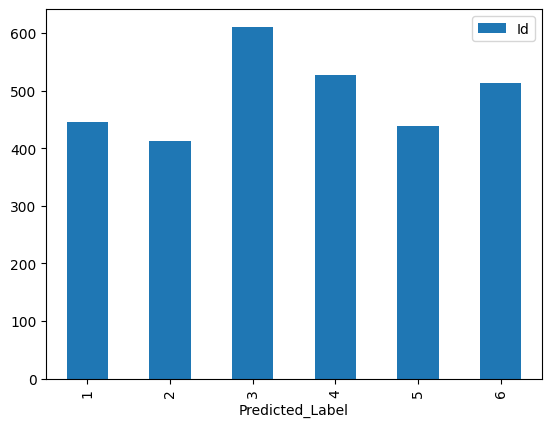

In [78]:
#predictions_df.groupby('Predicted_Label').count()
#Plot distribution of predicted labels
predictions_df.groupby('Predicted_Label').count().plot(kind='bar')


<Axes: xlabel='label'>

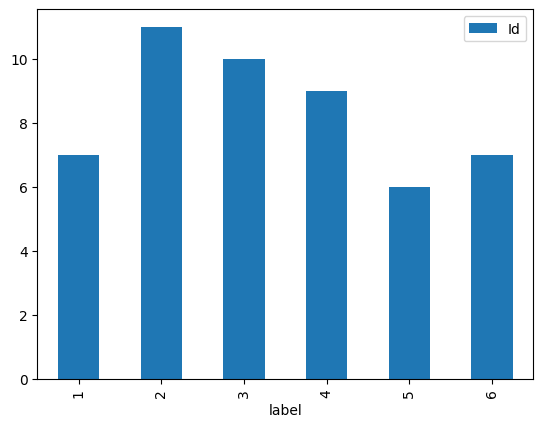

In [79]:
df_meta_model[['Id', 'label']].groupby('label').count().plot(kind='bar')